# Fast Neural Style Transfer

In [1]:
from collections import namedtuple
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm_notebook

from transformer_net import TransformerNet
from utils import gram_matrix, recover_image, tensor_normalizer

%matplotlib inline

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
DATASET = "coco/"
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [5]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [6]:
vgg_model = vgg.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
del vgg_model

In [8]:
STYLE_IMAGE = "style_images/udnie.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
style_img_tensor = transforms.Compose([
    transforms.ToTensor(),
    tensor_normalizer()]
)(style_img).unsqueeze(0)
# assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
if torch.cuda.is_available():
    style_img_tensor = style_img_tensor.cuda()

Sanity check:

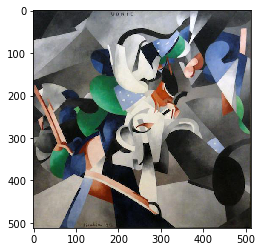

In [9]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

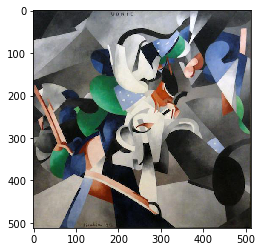

In [10]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [11]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
style_loss_features = loss_network(Variable(style_img_tensor, volatile=True))
gram_style = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features]

In [12]:
style_loss_features._fields

('relu1_2', 'relu2_2', 'relu3_3', 'relu4_3')

In [13]:
np.mean(gram_style[3].data.cpu().numpy())

0.021846615

In [14]:
np.mean(style_loss_features[0].data.cpu().numpy())

0.40428686

In [15]:
gram_style[0].numel()

4096

## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [16]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

In [17]:
%mkdir -p debug

In [18]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
if torch.cuda.is_available():
    transformer.cuda()

In [19]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 10
LOG_INTERVAL = 200
REGULARIZATION = 1e-8

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)

for epoch in range(2):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    count = 0
    for batch_id, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()
        x = Variable(x)
        if torch.cuda.is_available():
            x = x.cuda()

        y = transformer(x)
        xc = Variable(x.data, volatile=True)

        features_y = loss_network(y)
        features_xc = loss_network(xc)

        f_xc_c = Variable(features_xc[1].data, requires_grad=False)

        content_loss = CONTENT_WEIGHT * mse_loss(features_y[1], f_xc_c)

        reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        style_loss = 0.
        for m in range(len(features_y)):
            gram_s = gram_style[m]
            gram_y = gram_matrix(features_y[m])
            style_loss += STYLE_WEIGHT * mse_loss(gram_y, gram_s.expand_as(gram_y))

        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.data[0]
        agg_style_loss += style_loss.data[0]
        agg_reg_loss += reg_loss.data[0]

        if (batch_id + 1) % LOG_INTERVAL == 0:
            mesg = "{} [{}/{}] content: {:.6f}  style: {:.6f}  reg: {:.6f}  total: {:.6f}".format(
                        time.ctime(), count, len(train_dataset),
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL
                    )
            print(mesg)
            agg_content_loss = 0
            agg_style_loss = 0
            agg_reg_loss = 0
            save_debug_image(x.data, y.data, "debug/{}_{}.png".format(epoch, count))

Sat Jul 29 14:08:42 2017 [800/82783] content: 4.698005  style: 3.428840  reg: 0.001357  total: 8.128203
Sat Jul 29 14:09:58 2017 [1600/82783] content: 3.609330  style: 1.899327  reg: 0.001642  total: 5.510299
Sat Jul 29 14:11:13 2017 [2400/82783] content: 3.205920  style: 1.704826  reg: 0.001683  total: 4.912429
Sat Jul 29 14:12:28 2017 [3200/82783] content: 2.819247  style: 1.610148  reg: 0.001671  total: 4.431065
Sat Jul 29 14:13:43 2017 [4000/82783] content: 2.738777  style: 1.564685  reg: 0.001697  total: 4.305159
Sat Jul 29 14:14:58 2017 [4800/82783] content: 2.623859  style: 1.550024  reg: 0.001725  total: 4.175607
Sat Jul 29 14:16:14 2017 [5600/82783] content: 2.513076  style: 1.474819  reg: 0.001752  total: 3.989647
Sat Jul 29 14:17:29 2017 [6400/82783] content: 2.454899  style: 1.490816  reg: 0.001752  total: 3.947468
Sat Jul 29 14:18:44 2017 [7200/82783] content: 2.369468  style: 1.424800  reg: 0.001777  total: 3.796045
Sat Jul 29 14:19:59 2017 [8000/82783] content: 2.382397 

Sat Jul 29 15:46:23 2017 [63200/82783] content: 1.796486  style: 1.123739  reg: 0.003624  total: 2.923849
Sat Jul 29 15:47:38 2017 [64000/82783] content: 1.733103  style: 1.111901  reg: 0.003654  total: 2.848658
Sat Jul 29 15:48:53 2017 [64800/82783] content: 1.825473  style: 1.128376  reg: 0.003681  total: 2.957530
Sat Jul 29 15:50:09 2017 [65600/82783] content: 1.813953  style: 1.125386  reg: 0.003658  total: 2.942996
Sat Jul 29 15:51:24 2017 [66400/82783] content: 1.793522  style: 1.121683  reg: 0.003694  total: 2.918899
Sat Jul 29 15:52:39 2017 [67200/82783] content: 1.783833  style: 1.120262  reg: 0.003703  total: 2.907797
Sat Jul 29 15:53:55 2017 [68000/82783] content: 1.824619  style: 1.146419  reg: 0.003744  total: 2.974782
Sat Jul 29 15:55:10 2017 [68800/82783] content: 1.837617  style: 1.120011  reg: 0.003768  total: 2.961396
Sat Jul 29 15:56:25 2017 [69600/82783] content: 2.077112  style: 1.189026  reg: 0.003808  total: 3.269946
Sat Jul 29 15:57:41 2017 [70400/82783] content

Sat Jul 29 16:18:22 2017 [800/82783] content: 1.806528  style: 1.113791  reg: 0.004020  total: 2.924339
Sat Jul 29 16:19:37 2017 [1600/82783] content: 1.825277  style: 1.115651  reg: 0.004012  total: 2.944940
Sat Jul 29 16:20:53 2017 [2400/82783] content: 1.790007  style: 1.116862  reg: 0.004016  total: 2.910886
Sat Jul 29 16:22:08 2017 [3200/82783] content: 1.820613  style: 1.118391  reg: 0.004066  total: 2.943069
Sat Jul 29 16:23:23 2017 [4000/82783] content: 1.795344  style: 1.109025  reg: 0.004054  total: 2.908423
Sat Jul 29 16:24:38 2017 [4800/82783] content: 1.733177  style: 1.090261  reg: 0.004055  total: 2.827494
Sat Jul 29 16:25:54 2017 [5600/82783] content: 1.791116  style: 1.109073  reg: 0.004062  total: 2.904252
Sat Jul 29 16:27:09 2017 [6400/82783] content: 1.817020  style: 1.156055  reg: 0.004040  total: 2.977115
Sat Jul 29 16:28:25 2017 [7200/82783] content: 1.936732  style: 1.230846  reg: 0.004148  total: 3.171726
Sat Jul 29 16:29:40 2017 [8000/82783] content: 1.838570 

Sat Jul 29 17:56:09 2017 [63200/82783] content: 1.736240  style: 1.075781  reg: 0.004566  total: 2.816587
Sat Jul 29 17:57:23 2017 [64000/82783] content: 1.697430  style: 1.060157  reg: 0.004529  total: 2.762116
Sat Jul 29 17:58:37 2017 [64800/82783] content: 1.671013  style: 1.062670  reg: 0.004470  total: 2.738153
Sat Jul 29 17:59:51 2017 [65600/82783] content: 1.718480  style: 1.068508  reg: 0.004534  total: 2.791522
Sat Jul 29 18:01:05 2017 [66400/82783] content: 1.702070  style: 1.063947  reg: 0.004523  total: 2.770539
Sat Jul 29 18:02:19 2017 [67200/82783] content: 1.704254  style: 1.056905  reg: 0.004588  total: 2.765747
Sat Jul 29 18:03:32 2017 [68000/82783] content: 1.699281  style: 1.067809  reg: 0.004536  total: 2.771626
Sat Jul 29 18:04:46 2017 [68800/82783] content: 1.743061  style: 1.083239  reg: 0.004544  total: 2.830844
Sat Jul 29 18:06:00 2017 [69600/82783] content: 1.696947  style: 1.062952  reg: 0.004486  total: 2.764385
Sat Jul 29 18:07:14 2017 [70400/82783] content

In [20]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

82783

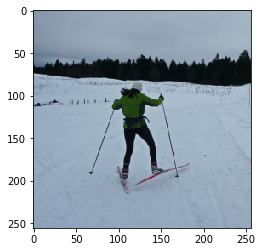

In [22]:
img = Image.open(fnames[40]).convert('RGB')
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

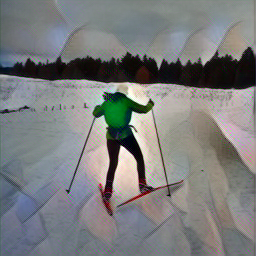

In [23]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

In [24]:
save_model_path = "model_udnie.pth"
torch.save(transformer.state_dict(), save_model_path)

In [25]:
transformer.load_state_dict(torch.load(save_model_path))

torch.Size([1, 3, 1080, 1080])


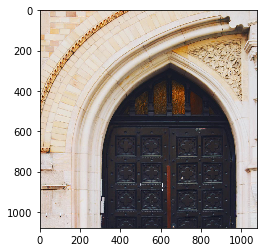

In [28]:
img = Image.open("content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

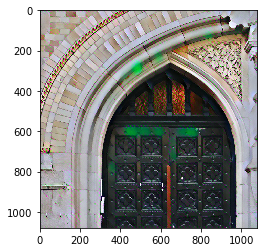

In [29]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [30]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")